# House price prediction for Denver Dataset

In this case (Part II), there are two main tasks:

- First, you will need to split the train data into train and validate data and tune the model hyperparameters to choose the best model. Submit the predicted prices for test data to Kaggle to compete for Prof. X's Prize!

- Then you will examine the profit of the iBuyer business model based on the predicted price on the valid data.






You need to submit a report in pdf format containing the following material on canvas site:

1.   A plot of the training errors and validation errors over epochs for a base multilayer perceptron model with 2 hidden layers of sizes 256 and 128.

2.   A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64.

3.  A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization.

4. A plot of the training errors and validation errors over epochs for a  multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64
and norm regularization and dropout layers.

5. A table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.

6. Your profit analysis of the the iBuyer business model based on the predicted price on the valid data and answers to the four questions therein.


You also need to submit on canvas site:

- The complete Juyputer notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.
-  A checkpoint.pth file containing all the necessary information to retrieve your best model and predictions.



---
## Data Loading and Visualize Data

The train data and test data are available on Kaggle website.
You can first download them, then upload them to the google colab, and then read the data using pandas.

In [ ]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
#TODO: Read the datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
# Display the train dataframe
print(train_df.shape)
print(train_df.columns)

(11581, 17)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS', 'SALE_PRICE'],
      dtype='object')


In [ ]:
# Display the test dataframe
print(test_df.shape)
print(test_df.columns)

(4964, 16)
Index(['ID', 'NBHD', 'PROP_CLASS', 'LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA',
       'LAND_SQFT', 'GRD_AREA', 'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B',
       'HLF_B', 'STORY', 'STYLE_CN', 'UNITS'],
      dtype='object')


As you can see, we have 11581 training samples and 4964 test samples, each with 16 features. The training samples contain the sale_prices, which are the labels. The test samples do not contain the sale_prices, which we will predict by building a MLP model.


### Visualization of SALE PRICES

Let's take a closer look at the sale prices in the train data.

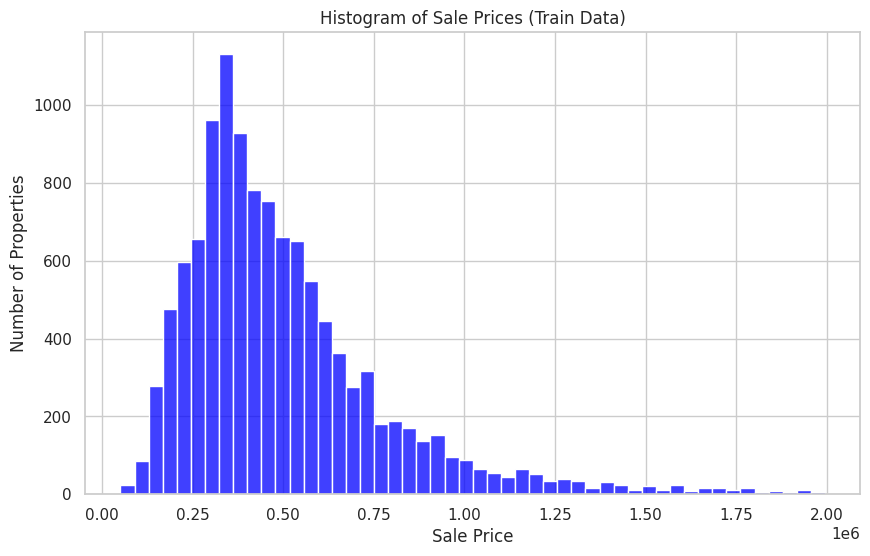

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot, it provides a MATLAB-like interface for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

Check the minimum and maximum sale_price in train data.

In [ ]:
print(train_df['SALE_PRICE'].min())
print(train_df['SALE_PRICE'].max())
print(train_df['SALE_PRICE'].median())

51000
1995000
431000.0


We see that the sale_price has a wide range from 50K to 2 million, with the median price 431K.

### Visualization of Correlation

We can also compute and visualize the correlation matrix.

<ipython-input-6-28da14c2e215>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


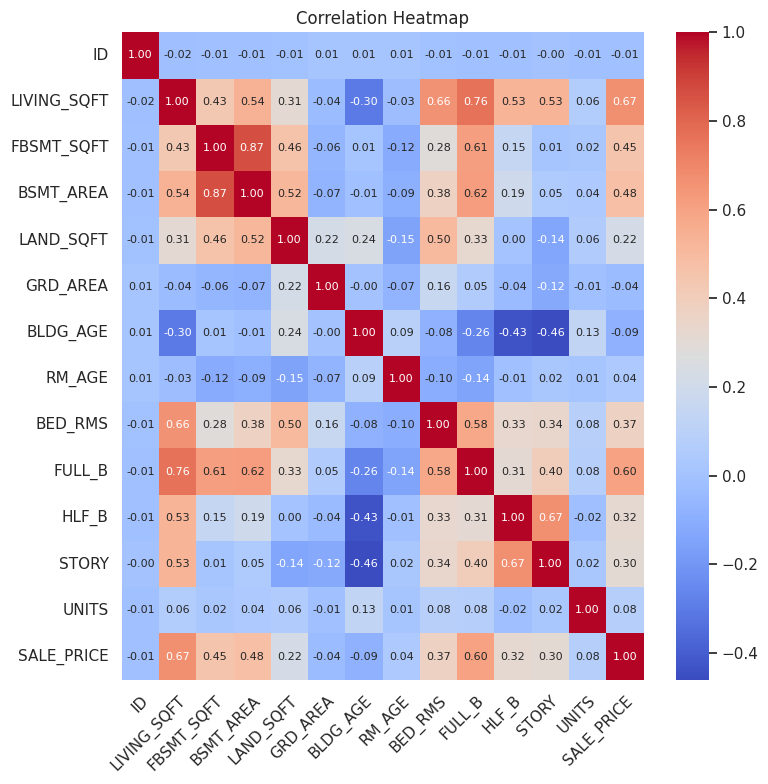

In [ ]:
# Compute the correlation matrix:
correlation_matrix = train_df.corr()

# 1. Increase the figure size for clarity
plt.figure(figsize=(8, 8))

# 2. Use a heatmap with annotations, a color map, and specific formatting for the annotations
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 8})

# 3. Rotate the x-axis labels for better visibility
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=0)

# 4. Title and display
plt.title('Correlation Heatmap')
plt.tight_layout()  # This can help if any labels are still being cut off
plt.show()

# 5. Optionally save the figure with high resolution
# plt.savefig("heatmap.png", dpi=300)

We can see that the Sale_Price has high correlation with Living_SQFT and number of Full Bathrooms.

### Distribution of houses over different NBHD

In [ ]:
# Compute the number of houses per neighborhood
House_by_NBHD = train_df['NBHD'].value_counts()
print(House_by_NBHD )

CENTRAL PARK                    1049
GATEWAY / GREEN VALLEY RANCH     937
UNION STATION                    369
HAMPDEN                          346
WINDSOR                          316
                                ... 
VALVERDE                          22
GLOBEVILLE                        20
SUN VALLEY                         8
CORY - MERRILL                     4
AURARIA                            1
Name: NBHD, Length: 75, dtype: int64


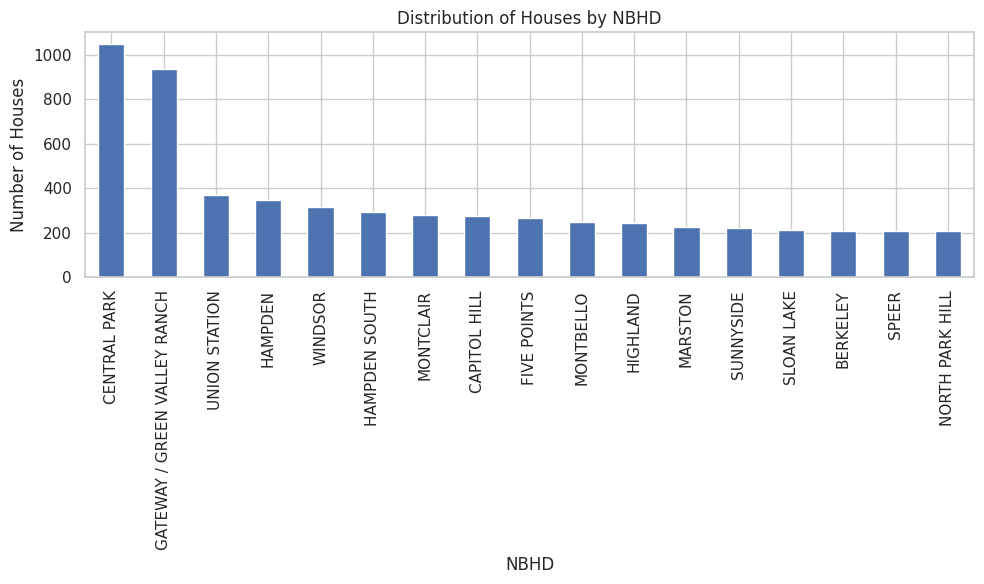

In [ ]:
# Filtering ZIP codes that appear more than once
filtered_House_by_NBHD = House_by_NBHD[House_by_NBHD > 200]
filtered_House_by_NBHD.plot(kind='bar', figsize=(10,6))
plt.title('Distribution of Houses by NBHD')
plt.ylabel('Number of Houses')
plt.xlabel('NBHD')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability, if necessary
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()


---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- Train labels: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. Note that here we combine the feature vectors in the train and test data. In this way, the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           4964 non-null   int64  
 1   NBHD         4964 non-null   object 
 2   PROP_CLASS   4964 non-null   object 
 3   LIVING_SQFT  4964 non-null   int64  
 4   FBSMT_SQFT   4964 non-null   int64  
 5   BSMT_AREA    4964 non-null   int64  
 6   LAND_SQFT    4964 non-null   int64  
 7   GRD_AREA     4964 non-null   int64  
 8   BLDG_AGE     4964 non-null   int64  
 9   RM_AGE       2623 non-null   float64
 10  BED_RMS      4964 non-null   float64
 11  FULL_B       4964 non-null   float64
 12  HLF_B        4964 non-null   int64  
 13  STORY        4964 non-null   float64
 14  STYLE_CN     4964 non-null   object 
 15  UNITS        4964 non-null   float64
dtypes: float64(5), int64(8), object(3)
memory usage: 620.6+ KB


We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [ ]:
#TODO: define labels for train data
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor
train_df.drop('SALE_PRICE', axis=1, inplace=True) # drop the sale_prices in features.

The inplace parameter, when set to True , allows you to drop the rows or columns without returning a new DataFrame. The issue arises when the drop function reorders the DataFrame, which can be problematic when the order of your data matters

Note that both the training samples and test samples contain an ID column, which is not informative for predicting the house price. Thus we will drop the ID column.

In [ ]:
train_ID=train_df['ID']
test_ID=test_df['ID']
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [ ]:
# Then we combine the feature vectors in the train data and test data
features=pd.concat(objs=[train_df,test_df],axis=0)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NBHD         16545 non-null  object 
 1   PROP_CLASS   16545 non-null  object 
 2   LIVING_SQFT  16545 non-null  int64  
 3   FBSMT_SQFT   16545 non-null  int64  
 4   BSMT_AREA    16545 non-null  int64  
 5   LAND_SQFT    16545 non-null  int64  
 6   GRD_AREA     16545 non-null  int64  
 7   BLDG_AGE     16545 non-null  int64  
 8   RM_AGE       8705 non-null   float64
 9   BED_RMS      16545 non-null  float64
 10  FULL_B       16545 non-null  float64
 11  HLF_B        16545 non-null  int64  
 12  STORY        16545 non-null  float64
 13  STYLE_CN     16545 non-null  object 
 14  UNITS        16545 non-null  float64
dtypes: float64(5), int64(7), object(3)
memory usage: 2.0+ MB


We see that there are three non-numeric features, namely `NBHD`, `PROP_CLASS`, and `STYLE_CN`. We will apply one-hot encoding to those non-numeric features in our model; you could also simply drop these non-numeric features.

In [ ]:
numeric_features = features.dtypes[features.dtypes != 'object'].index
non_numeric_features = features.dtypes[features.dtypes == 'object'].index
numeric_features, non_numeric_features

(Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
        'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B', 'STORY', 'UNITS'],
       dtype='object'),
 Index(['NBHD', 'PROP_CLASS', 'STYLE_CN'], dtype='object'))

In [ ]:
# If you want to drop the non-numeric features, you just set drop_non_numeric_features= True.
drop_non_numeric_features= False

if drop_non_numeric_features:
    features= features.drop(non_numeric_features, axis=1)
else:
    # One-hot encode categorical features
    features = pd.get_dummies(features, columns=non_numeric_features, dummy_na=True)

# Check for non-numeric columns
non_numeric_cols = features.select_dtypes(include=['object']).columns
if not non_numeric_cols.empty:
    raise ValueError(f"DataFrame contains non-numeric columns: {non_numeric_cols.tolist()}")

In [ ]:
# Standardize numeric features
features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [ ]:
# recheck the mean and std after standardization
features[numeric_features].mean(), features[numeric_features].std()

(LIVING_SQFT   -6.919686e-17
 FBSMT_SQFT    -7.907445e-17
 BSMT_AREA      5.829929e-17
 LAND_SQFT      1.792998e-17
 GRD_AREA      -1.975519e-17
 BLDG_AGE      -1.385011e-17
 RM_AGE         2.795645e-17
 BED_RMS        2.122341e-16
 FULL_B         1.469829e-16
 HLF_B         -5.658145e-17
 STORY         -4.563020e-18
 UNITS          5.017175e-16
 dtype: float64,
 LIVING_SQFT    1.0
 FBSMT_SQFT     1.0
 BSMT_AREA      1.0
 LAND_SQFT      1.0
 GRD_AREA       1.0
 BLDG_AGE       1.0
 RM_AGE         1.0
 BED_RMS        1.0
 FULL_B         1.0
 HLF_B          1.0
 STORY          1.0
 UNITS          1.0
 dtype: float64)

We see that after standardization, the features for the train data have mean 0 and standard deviation 1.

In [ ]:
# After the feature standardization, we can impute the missing values with zeros.
features[numeric_features] = features[numeric_features].fillna(0)

Double check the features after data processing.

In [ ]:
features.info()
print(features.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16545 entries, 0 to 4963
Columns: 105 entries, LIVING_SQFT to STYLE_CN_nan
dtypes: float64(12), uint8(93)
memory usage: 3.1 MB
Index(['LIVING_SQFT', 'FBSMT_SQFT', 'BSMT_AREA', 'LAND_SQFT', 'GRD_AREA',
       'BLDG_AGE', 'RM_AGE', 'BED_RMS', 'FULL_B', 'HLF_B',
       ...
       'STYLE_CN_3 STORY', 'STYLE_CN_BI-LEVEL', 'STYLE_CN_CONVERSION',
       'STYLE_CN_END UNIT', 'STYLE_CN_MIDDLE UNIT', 'STYLE_CN_RANCH',
       'STYLE_CN_SPLIT LEVEL', 'STYLE_CN_TRI-LEVEL', 'STYLE_CN_TRI-LEVEL W/B',
       'STYLE_CN_nan'],
      dtype='object', length=105)


Note that after the one-hot encoding of the non-numeric features, now we have 105-dimensional feature.

In [ ]:
# check whether there is any missing entry
print(features.isnull().sum())

LIVING_SQFT               0
FBSMT_SQFT                0
BSMT_AREA                 0
LAND_SQFT                 0
GRD_AREA                  0
                         ..
STYLE_CN_RANCH            0
STYLE_CN_SPLIT LEVEL      0
STYLE_CN_TRI-LEVEL        0
STYLE_CN_TRI-LEVEL W/B    0
STYLE_CN_nan              0
Length: 105, dtype: int64


In [ ]:
# we extract out the train and test features
train_features = features.iloc[:len(train_labels)]
test_features = features.iloc[len(train_labels):]
train_features.shape, test_features.shape

((11581, 105), (4964, 105))

In [ ]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)

In [ ]:
train_labels

tensor([[ 2.8500],
        [12.3000],
        [ 4.2000],
        ...,
        [ 6.0200],
        [ 3.8370],
        [ 5.5000]])

In [ ]:
train_labels.shape

torch.Size([11581, 1])

---
## Training and Validation

To prevent overfitting, we'll split it our training data into training and validation. We will use validation set to select the appropriate model.
One way is to use the [`train_test_split` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). You're more than welcome to use your own way.

In [ ]:
#TODO: filling in the missing code to split train data into train and validation
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn for splitting data into training set and validation set
# Splitting the training data: 20% is validation data
train_indices, valid_indices = train_test_split(
    np.arange(len(features)), test_size=0.2, random_state=42)

train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42)

In [ ]:
print(train_features.shape)
print(valid_features.shape)

torch.Size([9264, 105])
torch.Size([2317, 105])


---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For valid and test data, we do not shuffle.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
#TODO: create dataloader for validation data
valid_loader =DataLoader(TensorDataset(valid_features, valid_labels),batch_size=128)

In [ ]:
test_data = TensorDataset(test_features)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Let's take a batch to have a sanity check

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([128, 105])
Sample input: 
 tensor([[-0.9552, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2974,  0.8265,  0.5933,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2116,  0.6458,  0.4813,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.1478, -0.6920,  0.3295,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1395, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000],
        [-0.7977, -0.6920, -0.8231,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([128, 1])
Sample label: 
 tensor([[ 1.6200],
        [ 4.9300],
        [ 7.3750],
        [ 6.7500],
        [ 3.7000],
        [ 5.3500],
        [ 4.2000],
        [ 3.5840],
        [ 3.4500],
        [ 4.0250],
        [ 5.6200],
        [ 4.6300],
        [ 5.0645],
        [ 3.6740],
        [15.5000],
        [ 2.0000],
        [12.7539],
        [ 6.2500],
        [14.4000],
        [ 1.1667],
        [ 1.3500],
        [ 5.3500],
        [ 3.2000],
        [ 7.

---
## Linear Regression as Benchmark

Let us build a linear regression model as a benchmark. Note that the linear regression model can be viewed as a special instance of multi-layer perception with no hidden layer and a single output neuron.

In [ ]:
# Build a linear regression model network
import torch.nn as nn
lin_net = nn.Linear(train_features.shape[1], 1)

Let's print out the model achitecture.

In [ ]:
lin_net

Linear(in_features=105, out_features=1, bias=True)

Let's take a batch and see the output

In [ ]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

---
## Train the model

First, we will use GPU training if it is availabe.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lin_net = lin_net.to(device)

Second, let us specify the loss function.

In [ ]:
#Since both the output and the label are real valued, we will use the standard mean-squared loss.
import torch
import torch.nn as nn

class MedianErrorRateLoss(nn.Module):
    def __init__(self):
        super(MedianErrorRateLoss, self).__init__()

    def forward(self, predicted, actual):
        # Calculate the absolute error for each prediction
        absolute_error = torch.abs((predicted - actual)/actual)

        return absolute_error

# Example usage:
criterion = MedianErrorRateLoss()

Third, while we are using the mean-squared loss for training loss, we will use
a different metric to measure the predictive performance.

Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To address this issue, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

We are now ready to train the network. Let’s try training the model a bit longer: 200 epochs. To keep a record of how well the model does at each epoch, we will save the per-epoch training error and validation error in the training loop.

In [ ]:
#TODO: Write code to train the network and save training and validation error.
def train(model, train_loader, valid_loader,num_epochs,learning_rate=0.001):
    train_losses = []                                       # To store training losses
    train_errors = []
    valid_losses=[]
    valid_errors=[]
    # To store training error rates
    # Initialize the optimizer, we use Adam here
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        tot_valid_loss = 0.0
        tot_train_loss = 0.0                            # Store the total training MSE loss for this epoch
        train_error_rates =torch.tensor([]).to(device)  # Store the training error rates for this epoch
        valid_error_rates=torch.tensor([]).to(device)
        for features, labels in train_loader:           # For each batch in DataLoader
            # Move data to device (GPU or CPU)
            features = features.to(device)
            labels = labels.to(device)

            output = model(features)  # Compute the output
            loss = criterion(output, labels)  # Compute loss
            optimizer.zero_grad()  # Clear the gradients from previous iteration
            loss = loss.mean()
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update the weights

            tot_train_loss += loss.item()

            # Compute and store error rate for training data
            train_error_rate = torch.absolute(output/labels-1)
            train_error_rates= torch.cat((train_error_rates,train_error_rate),dim=0)


        train_loss = tot_train_loss /len(train_loader)
        train_error = torch.median(train_error_rates).item()
        train_losses.append(train_loss)
        train_errors.append(train_error)


        for valid_features, valid_labels in valid_loader:

            valid_features = valid_features.to(device)
            valid_labels = valid_labels.to(device)

            output = lin_net(valid_features)
            loss = criterion(output, valid_labels)
            optimizer.zero_grad()
            loss = loss.mean()
            loss.backward()
            optimizer.step()

            tot_valid_loss += loss.item()

            valid_error_rate = torch.absolute(output/valid_labels-1)
            valid_error_rates= torch.cat((valid_error_rates,valid_error_rate),dim=0)

        valid_loss = tot_valid_loss /len(valid_loader)
        valid_error = torch.median(valid_error_rates).item()
        valid_losses.append(valid_loss)
        valid_errors.append(valid_error)

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
          "Train Loss: {:.3f}.. ".format(train_loss),
          "Train Median Error Rate: {:.3f}.. ".format(train_error),
          "Validation Loss: {:.3f}.. ".format(valid_loss),
          "Validation Median Error Rate: {:.3f}.. ".format(valid_error))


        # Print the training loss and validation loss every 10 epochs
        if epoch % 10 == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Train Median Error Rate: {:.3f}.. ".format(train_error),
              )


    return  train_losses,train_errors,valid_losses,valid_errors

In [ ]:
train_losses,train_errors,valid_losses,valid_errors = train(lin_net, train_loader,valid_loader, num_epochs=200,learning_rate=0.001)

Epoch: 1/200..  Train Loss: 0.192..  Train Median Error Rate: 0.123..  Validation Loss: 0.181..  Validation Median Error Rate: 0.127.. 
Epoch: 1/200..  Train Loss: 0.192..  Train Median Error Rate: 0.123.. 
Epoch: 2/200..  Train Loss: 0.192..  Train Median Error Rate: 0.123..  Validation Loss: 0.181..  Validation Median Error Rate: 0.126.. 
Epoch: 3/200..  Train Loss: 0.192..  Train Median Error Rate: 0.122..  Validation Loss: 0.181..  Validation Median Error Rate: 0.127.. 
Epoch: 4/200..  Train Loss: 0.192..  Train Median Error Rate: 0.122..  Validation Loss: 0.181..  Validation Median Error Rate: 0.127.. 
Epoch: 5/200..  Train Loss: 0.192..  Train Median Error Rate: 0.123..  Validation Loss: 0.181..  Validation Median Error Rate: 0.126.. 
Epoch: 6/200..  Train Loss: 0.192..  Train Median Error Rate: 0.123..  Validation Loss: 0.181..  Validation Median Error Rate: 0.126.. 
Epoch: 7/200..  Train Loss: 0.192..  Train Median Error Rate: 0.123..  Validation Loss: 0.181..  Validation Media

Define a function to plot errors.

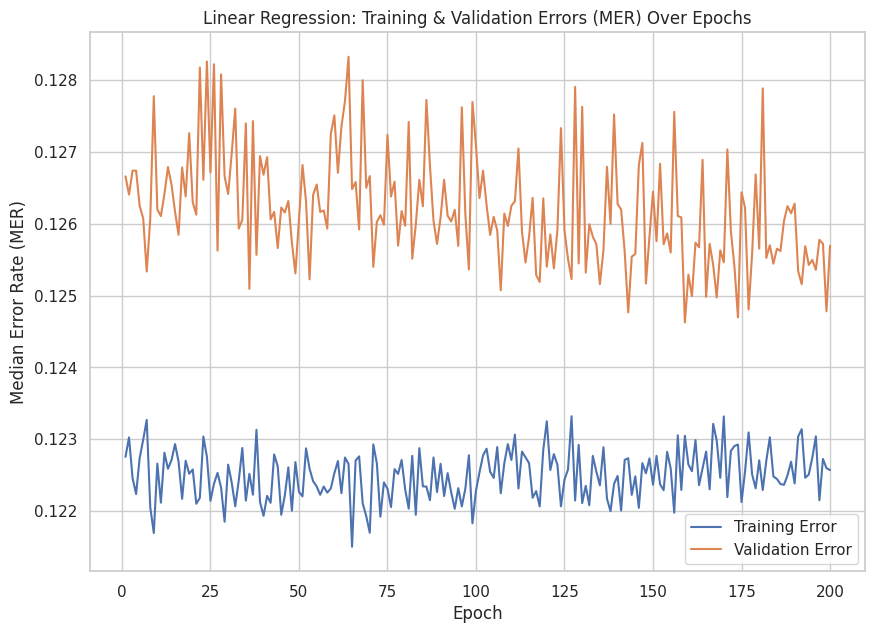

In [ ]:
#TODO: Write code to plot the training and vadliation errors (MER) over epochs
import matplotlib.pyplot as plt

def plot_errors(errors1, errors2, num_epochs, label1, label2, title):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), errors1, label=label1)
    plt.plot(range(1, num_epochs + 1), errors2, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Median Error Rate (MER)')
    plt.title(title)
    plt.legend()
    plt.show()
plot_errors(train_errors, valid_errors, num_epochs=200, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations.

In [ ]:
# Build a feed-forward network
import torch.nn as nn
model1 = nn.Sequential(nn.Linear(train_features.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

Let's print out the model achitecture.

In [ ]:
model1

Sequential(
  (0): Linear(in_features=105, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
model1 = model1.to(device)

In [ ]:
#TODO: write code to train the MLP network and save training and validation error.
def train(model, train_loader, valid_loader,num_epochs,learning_rate):
    train_losses = []                                       # To store training losses
    train_errors = []
    valid_losses=[]
    valid_errors=[]
    # To store training error rates
    # Initialize the optimizer, we use Adam here
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        tot_valid_loss = 0.0
        tot_train_loss = 0.0                            # Store the total training MSE loss for this epoch
        train_error_rates =torch.tensor([]).to(device)  # Store the training error rates for this epoch
        valid_error_rates=torch.tensor([]).to(device)
        for features, labels in train_loader:           # For each batch in DataLoader
            # Move data to device (GPU or CPU)
            features = features.to(device)
            labels = labels.to(device)

            output = model(features)  # Compute the output
            loss = criterion(output, labels)  # Compute loss
            optimizer.zero_grad()  # Clear the gradients from previous iteration
            loss = loss.mean()
            loss.backward()  # Backpropagate the error

            optimizer.step()  # Update the weights

            tot_train_loss += loss.item()

            # Compute and store error rate for training data
            train_error_rate = torch.absolute(output/labels-1)
            train_error_rates= torch.cat((train_error_rates,train_error_rate),dim=0)


        train_loss = tot_train_loss /len(train_loader)
        train_error = torch.median(train_error_rates).item()
        train_losses.append(train_loss)
        train_errors.append(train_error)


        for valid_features, valid_labels in valid_loader:

            valid_features = valid_features.to(device)
            valid_labels = valid_labels.to(device)

            output = model(valid_features)
            loss = criterion(output, valid_labels)
            optimizer.zero_grad()
            loss = loss.mean()
            loss.backward()
            optimizer.step()

            tot_valid_loss += loss.item()

            valid_error_rate = torch.absolute(output/valid_labels-1)
            valid_error_rates= torch.cat((valid_error_rates,valid_error_rate),dim=0)

        valid_loss = tot_valid_loss /len(valid_loader)
        valid_error = torch.median(valid_error_rates).item()
        valid_losses.append(valid_loss)
        valid_errors.append(valid_error)

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
          "Train Loss: {:.3f}.. ".format(train_loss),
          "Train Median Error Rate: {:.3f}.. ".format(train_error),
          "Validation Loss: {:.3f}.. ".format(valid_loss),
          "Validation Median Error Rate: {:.3f}.. ".format(valid_error))


        # Print the training loss and validation loss every 10 epochs
        if epoch % 10 == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Train Median Error Rate: {:.3f}.. ".format(train_error),
              )


    return  train_losses,train_errors,valid_losses,valid_errors

In [ ]:
train_losses,train_errors,valid_losses,valid_errors = train(model1, train_loader,valid_loader, num_epochs=100,learning_rate=0.001)

Epoch: 1/100..  Train Loss: 0.415..  Train Median Error Rate: 0.320..  Validation Loss: 0.213..  Validation Median Error Rate: 0.154.. 
Epoch: 1/100..  Train Loss: 0.415..  Train Median Error Rate: 0.320.. 
Epoch: 2/100..  Train Loss: 0.199..  Train Median Error Rate: 0.127..  Validation Loss: 0.177..  Validation Median Error Rate: 0.117.. 
Epoch: 3/100..  Train Loss: 0.183..  Train Median Error Rate: 0.113..  Validation Loss: 0.166..  Validation Median Error Rate: 0.109.. 
Epoch: 4/100..  Train Loss: 0.175..  Train Median Error Rate: 0.106..  Validation Loss: 0.162..  Validation Median Error Rate: 0.109.. 
Epoch: 5/100..  Train Loss: 0.171..  Train Median Error Rate: 0.104..  Validation Loss: 0.157..  Validation Median Error Rate: 0.105.. 
Epoch: 6/100..  Train Loss: 0.165..  Train Median Error Rate: 0.098..  Validation Loss: 0.156..  Validation Median Error Rate: 0.105.. 
Epoch: 7/100..  Train Loss: 0.163..  Train Median Error Rate: 0.098..  Validation Loss: 0.153..  Validation Media

## 1. A plot of the training errors and validation errors over epochs for a base multilayer perceptron model with 2 hidden layers of sizes 256 and 128.


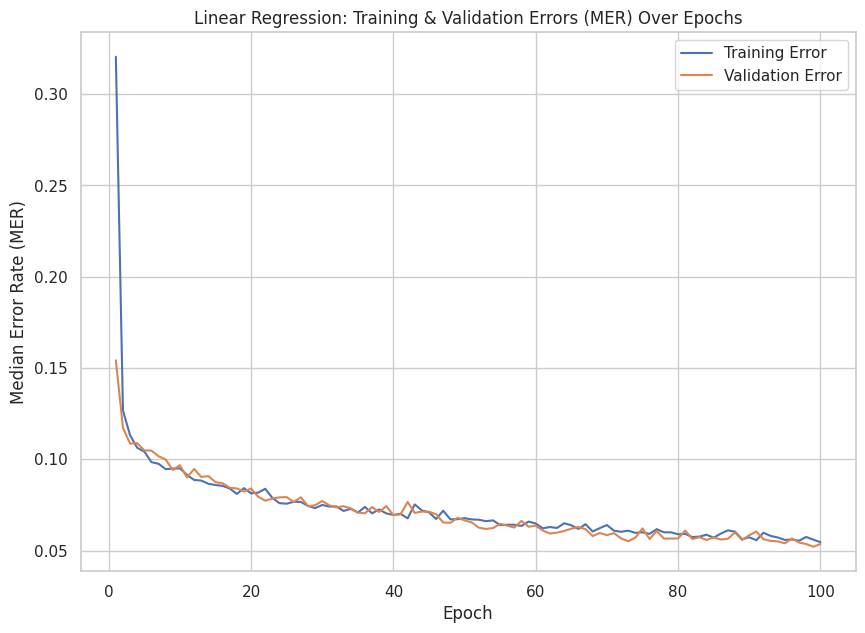

In [ ]:
#TODO: Write code to plot the training and validation error (MER) over epochs
plot_errors(train_errors, valid_errors, num_epochs=100, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')

---
## Change network architecture


In the following, build a MLP with 4 hidden layer of sizes 512, 256, 128, 64, respectively.  

In [ ]:
#TODO: building a MLP with 4 hidden layer of sizes 512, 256, 128, 64,
model2 = nn.Sequential(nn.Linear(train_features.shape[1], 512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.ReLU(),
                      nn.Linear(256,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,1))
model2 = model2.to(device)

In [ ]:
rain_losses,train_errors,valid_losses,valid_errors = train(model2, train_loader,valid_loader, num_epochs=100,learning_rate=0.001)

Epoch: 1/100..  Train Loss: 0.373..  Train Median Error Rate: 0.253..  Validation Loss: 0.203..  Validation Median Error Rate: 0.139.. 
Epoch: 1/100..  Train Loss: 0.373..  Train Median Error Rate: 0.253.. 
Epoch: 2/100..  Train Loss: 0.195..  Train Median Error Rate: 0.126..  Validation Loss: 0.173..  Validation Median Error Rate: 0.118.. 
Epoch: 3/100..  Train Loss: 0.178..  Train Median Error Rate: 0.112..  Validation Loss: 0.163..  Validation Median Error Rate: 0.113.. 
Epoch: 4/100..  Train Loss: 0.171..  Train Median Error Rate: 0.108..  Validation Loss: 0.156..  Validation Median Error Rate: 0.106.. 
Epoch: 5/100..  Train Loss: 0.164..  Train Median Error Rate: 0.104..  Validation Loss: 0.151..  Validation Median Error Rate: 0.100.. 
Epoch: 6/100..  Train Loss: 0.161..  Train Median Error Rate: 0.101..  Validation Loss: 0.150..  Validation Median Error Rate: 0.100.. 
Epoch: 7/100..  Train Loss: 0.159..  Train Median Error Rate: 0.101..  Validation Loss: 0.152..  Validation Media

## 2. A plot of the training errors and validation errors over epochs for a multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64.

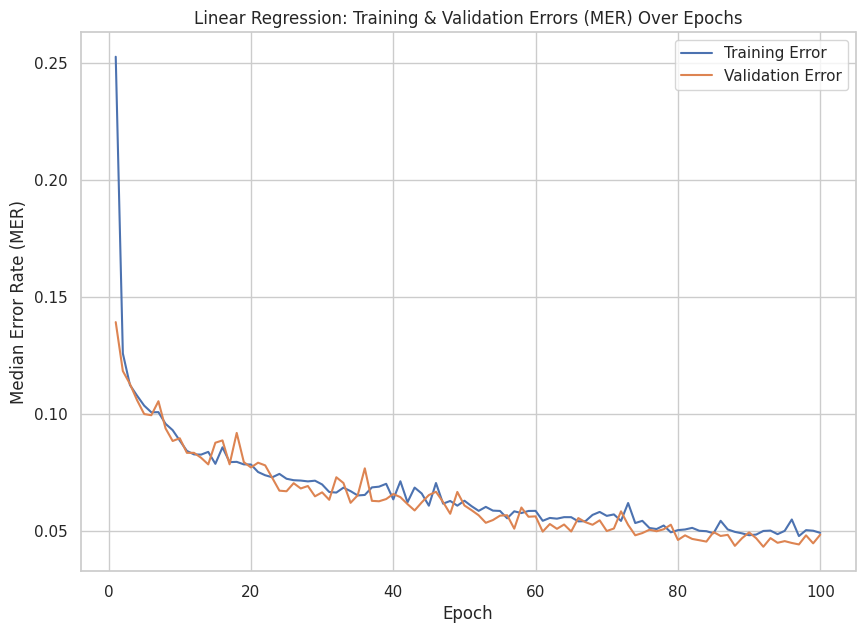

In [ ]:
#TODO: plot the training and validation error (MER) over epochs
plot_errors(train_errors, valid_errors, num_epochs=100, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')

---
## Add norm regularization

In the following, use the norm regularization to retrain the above MLP.

In [ ]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
def train(model, train_loader, valid_loader,weight_decay,num_epochs,learning_rate):
    train_losses = []                                       # To store training losses
    train_errors = []
    valid_losses=[]
    valid_errors=[]
    # To store training error rates
    # Initialize the optimizer, we use Adam here
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        tot_valid_loss = 0.0
        tot_train_loss = 0.0                            # Store the total training MSE loss for this epoch
        train_error_rates =torch.tensor([]).to(device)  # Store the training error rates for this epoch
        valid_error_rates=torch.tensor([]).to(device)
        for features, labels in train_loader:           # For each batch in DataLoader
            # Move data to device (GPU or CPU)
            features = features.to(device)
            labels = labels.to(device)

            output = model(features)  # Compute the output
            loss = criterion(output, labels)  # Compute loss
            loss = loss.mean()
            optimizer.zero_grad()  # Clear the gradients from previous iteration
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update the weights

            tot_train_loss += loss.item()

            # Compute and store error rate for training data
            train_error_rate = torch.absolute(output/labels-1)
            train_error_rates= torch.cat((train_error_rates,train_error_rate),dim=0)


        train_loss = tot_train_loss /len(train_loader)
        train_error = torch.median(train_error_rates).item()
        train_losses.append(train_loss)
        train_errors.append(train_error)


        for valid_features, valid_labels in valid_loader:

            valid_features = valid_features.to(device)
            valid_labels = valid_labels.to(device)
            output = model(valid_features)
            loss = criterion(output, valid_labels)
            loss = loss.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tot_valid_loss += loss.item()

            valid_error_rate = torch.absolute(output/valid_labels-1)
            valid_error_rates= torch.cat((valid_error_rates,valid_error_rate),dim=0)

        valid_loss = tot_valid_loss /len(valid_loader)
        valid_error = torch.median(valid_error_rates).item()
        valid_losses.append(valid_loss)
        valid_errors.append(valid_error)

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
          "Train Loss: {:.3f}.. ".format(train_loss),
          "Train Median Error Rate: {:.3f}.. ".format(train_error),
          "Validation Loss: {:.3f}.. ".format(valid_loss),
          "Validation Median Error Rate: {:.3f}.. ".format(valid_error))


        # Print the training loss and validation loss every 10 epochs
        if epoch % 10 == 0:
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Train Loss: {:.3f}.. ".format(train_loss),
              "Train Median Error Rate: {:.3f}.. ".format(train_error),
              )


    return  train_losses,train_errors,valid_losses,valid_errors

In [ ]:
train_losses,train_errors,valid_losses,valid_errors = train(model2, train_loader,valid_loader,weight_decay=0.00001, num_epochs=100,learning_rate=0.0005)

Epoch: 1/100..  Train Loss: 0.082..  Train Median Error Rate: 0.042..  Validation Loss: 0.083..  Validation Median Error Rate: 0.048.. 
Epoch: 1/100..  Train Loss: 0.082..  Train Median Error Rate: 0.042.. 
Epoch: 2/100..  Train Loss: 0.083..  Train Median Error Rate: 0.043..  Validation Loss: 0.084..  Validation Median Error Rate: 0.049.. 
Epoch: 3/100..  Train Loss: 0.080..  Train Median Error Rate: 0.041..  Validation Loss: 0.077..  Validation Median Error Rate: 0.040.. 
Epoch: 4/100..  Train Loss: 0.077..  Train Median Error Rate: 0.038..  Validation Loss: 0.076..  Validation Median Error Rate: 0.039.. 
Epoch: 5/100..  Train Loss: 0.077..  Train Median Error Rate: 0.037..  Validation Loss: 0.079..  Validation Median Error Rate: 0.041.. 
Epoch: 6/100..  Train Loss: 0.079..  Train Median Error Rate: 0.039..  Validation Loss: 0.076..  Validation Median Error Rate: 0.039.. 
Epoch: 7/100..  Train Loss: 0.078..  Train Median Error Rate: 0.039..  Validation Loss: 0.075..  Validation Media

## 3. A plot of the training errors and validation errors over epochs for a multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64 and norm regularization.

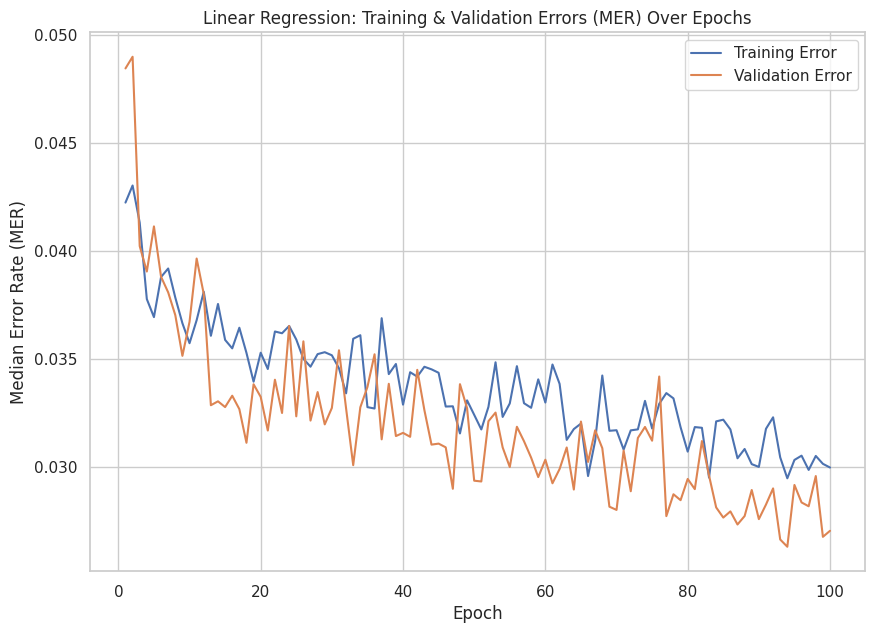

In [ ]:
plot_errors(train_errors, valid_errors, num_epochs=100, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')

---
## Add dropout layer

In the following, add dropout layer to the above MLP.


In [ ]:
#TODO: plot the training and validation error (MER) over epochs after using norm regularization
model3 = nn.Sequential(nn.Linear(train_features.shape[1], 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))
model3 = model3.to(device)
train_losses,train_errors,valid_losses,valid_errors = train(model3, train_loader,valid_loader,weight_decay=0.00001, num_epochs=200,learning_rate=0.001)

Epoch: 1/200..  Train Loss: 0.397..  Train Median Error Rate: 0.285..  Validation Loss: 0.223..  Validation Median Error Rate: 0.165.. 
Epoch: 1/200..  Train Loss: 0.397..  Train Median Error Rate: 0.285.. 
Epoch: 2/200..  Train Loss: 0.216..  Train Median Error Rate: 0.153..  Validation Loss: 0.186..  Validation Median Error Rate: 0.137.. 
Epoch: 3/200..  Train Loss: 0.194..  Train Median Error Rate: 0.131..  Validation Loss: 0.181..  Validation Median Error Rate: 0.135.. 
Epoch: 4/200..  Train Loss: 0.187..  Train Median Error Rate: 0.126..  Validation Loss: 0.178..  Validation Median Error Rate: 0.130.. 
Epoch: 5/200..  Train Loss: 0.184..  Train Median Error Rate: 0.127..  Validation Loss: 0.174..  Validation Median Error Rate: 0.130.. 
Epoch: 6/200..  Train Loss: 0.179..  Train Median Error Rate: 0.122..  Validation Loss: 0.169..  Validation Median Error Rate: 0.126.. 
Epoch: 7/200..  Train Loss: 0.174..  Train Median Error Rate: 0.119..  Validation Loss: 0.164..  Validation Media

## 4.  A plot of the training errors and validation errors over epochs for a multilayer perceptron model with 4 hidden layers of sizes 512, 256, 128, 64 and norm regularization and dropout layers.

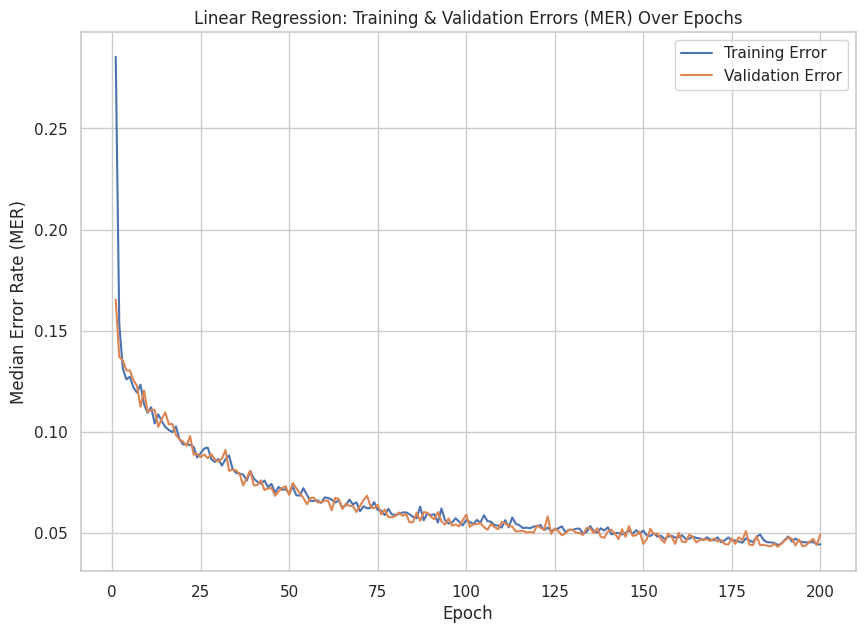

In [ ]:
plot_errors(train_errors, valid_errors, num_epochs=200, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')

## Some other model variations

**You're more than welcome to try some other model varations (e.g. different number of hidden layers, hidden neurons, learning rate, etc) to achieve lower valid error. Include a table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.**

In [ ]:
#Number of layers
#Number of neurons
#Learning rate
#Regularization
#dropout layer
model4=nn.Sequential(nn.Linear(train_features.shape[1], 71),
                      nn.ReLU(),
                      nn.Linear(71,1024),
                      nn.ReLU(),
                      nn.Linear(1024,512),
                      nn.ReLU(),
                     nn.Linear(512,256),
                      nn.ReLU(),
                     nn.Linear(256,128),
                      nn.ReLU(),
                     #nn.Linear(128,64),
                     #nn.ReLU(),
                      nn.Linear(128,1))
model4 = model4.to(device)
train_losses,train_errors,valid_losses,valid_errors = train(model4, train_loader,valid_loader,weight_decay=0.00001, num_epochs=700,learning_rate=0.0005)

Epoch: 1/700..  Train Loss: 0.413..  Train Median Error Rate: 0.309..  Validation Loss: 0.243..  Validation Median Error Rate: 0.183.. 
Epoch: 1/700..  Train Loss: 0.413..  Train Median Error Rate: 0.309.. 
Epoch: 2/700..  Train Loss: 0.218..  Train Median Error Rate: 0.147..  Validation Loss: 0.183..  Validation Median Error Rate: 0.129.. 
Epoch: 3/700..  Train Loss: 0.179..  Train Median Error Rate: 0.117..  Validation Loss: 0.163..  Validation Median Error Rate: 0.112.. 
Epoch: 4/700..  Train Loss: 0.169..  Train Median Error Rate: 0.107..  Validation Loss: 0.158..  Validation Median Error Rate: 0.108.. 
Epoch: 5/700..  Train Loss: 0.164..  Train Median Error Rate: 0.102..  Validation Loss: 0.155..  Validation Median Error Rate: 0.107.. 
Epoch: 6/700..  Train Loss: 0.161..  Train Median Error Rate: 0.097..  Validation Loss: 0.152..  Validation Median Error Rate: 0.104.. 
Epoch: 7/700..  Train Loss: 0.155..  Train Median Error Rate: 0.094..  Validation Loss: 0.148..  Validation Media

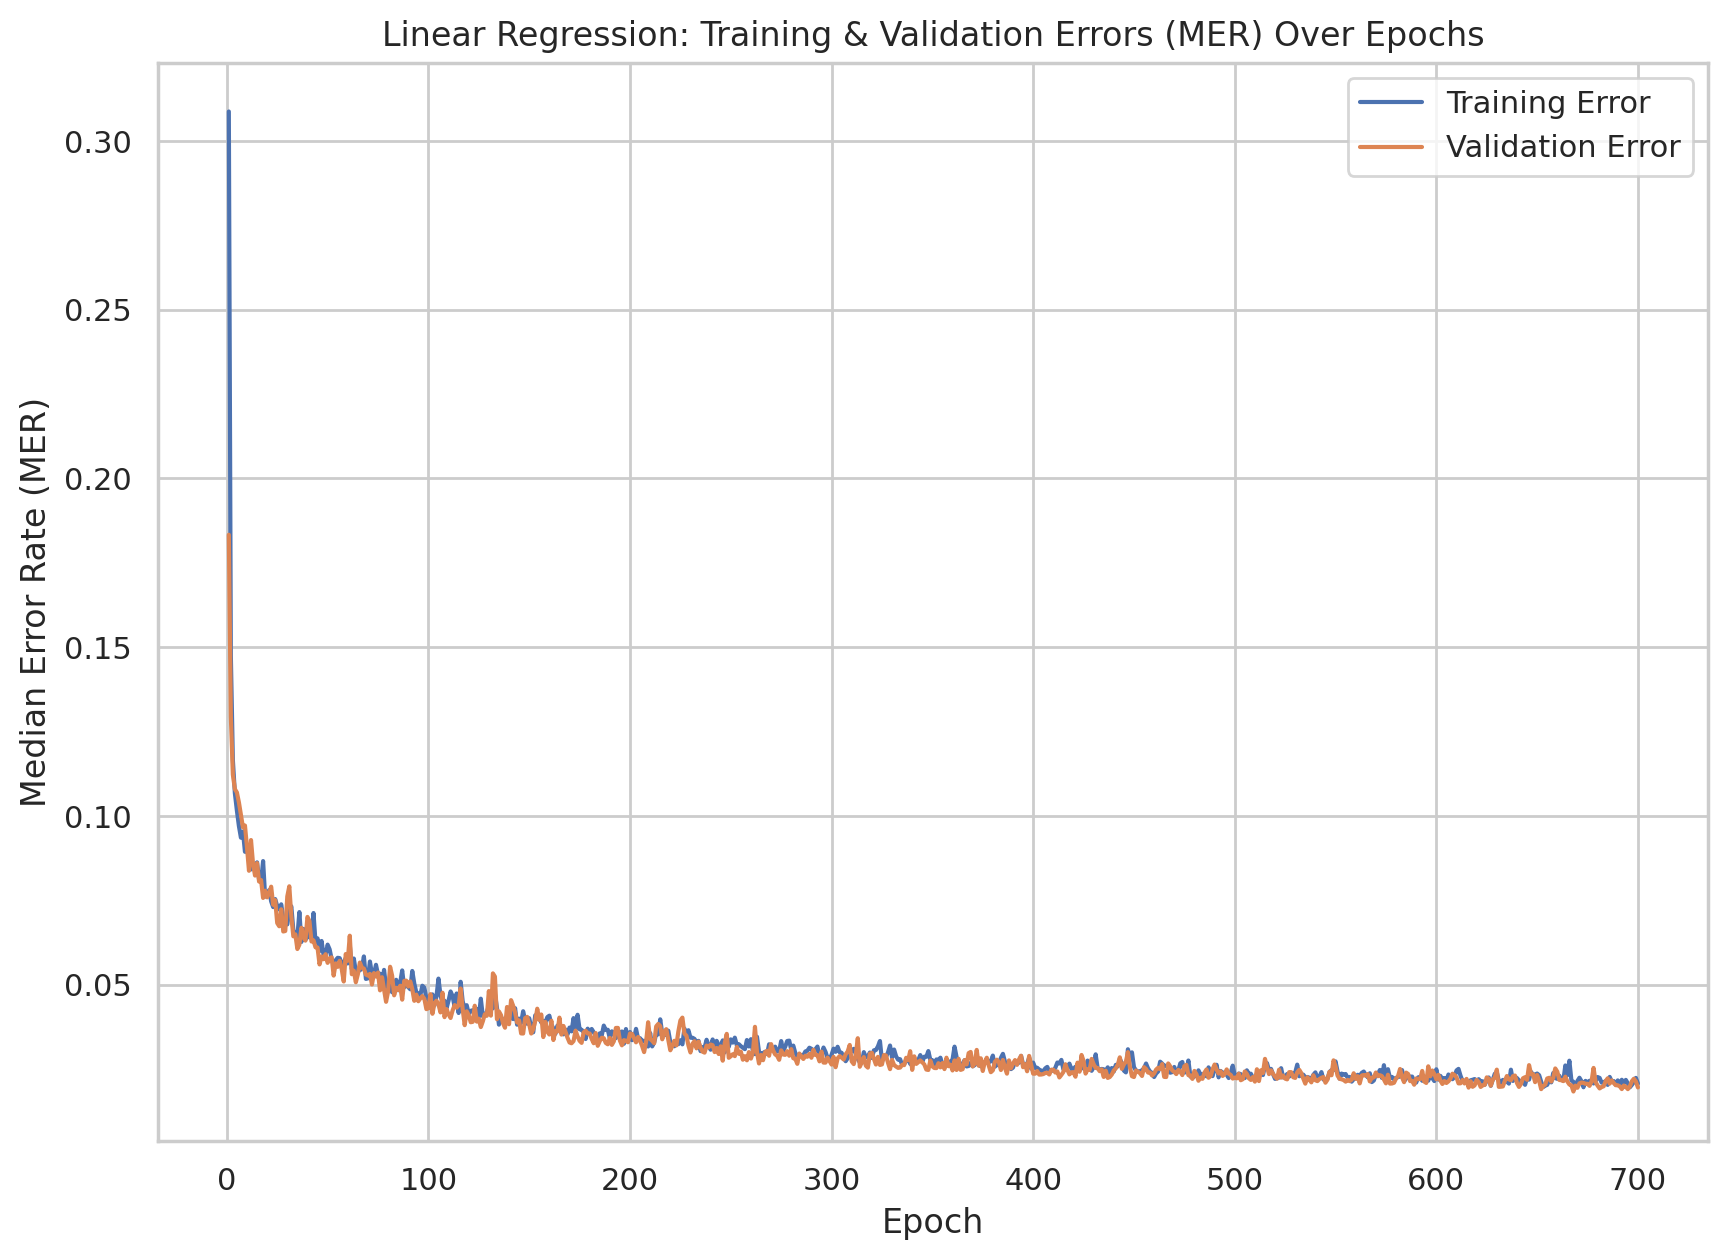

In [ ]:
plot_errors(train_errors, valid_errors, num_epochs=700, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')


In [ ]:
model5=nn.Sequential(nn.Linear(train_features.shape[1], 71),
                      nn.ReLU(),
                      nn.Linear(71,2048),
                      nn.ReLU(),
                      nn.Linear(2048,1024),
                      nn.ReLU(),
                      nn.Linear(1024,512),
                      nn.ReLU(),
                      nn.Linear(512,64),
                      nn.ReLU(),
                      nn.Linear(64,1))

model5 = model5.to(device)
train_losses,train_errors,valid_losses,valid_errors = train(model5, train_loader,valid_loader,weight_decay=0.00001, num_epochs=700,learning_rate=0.0005)

Epoch: 1/700..  Train Loss: 0.358..  Train Median Error Rate: 0.252..  Validation Loss: 0.220..  Validation Median Error Rate: 0.162.. 
Epoch: 1/700..  Train Loss: 0.358..  Train Median Error Rate: 0.252.. 
Epoch: 2/700..  Train Loss: 0.198..  Train Median Error Rate: 0.131..  Validation Loss: 0.183..  Validation Median Error Rate: 0.130.. 
Epoch: 3/700..  Train Loss: 0.177..  Train Median Error Rate: 0.116..  Validation Loss: 0.159..  Validation Median Error Rate: 0.108.. 
Epoch: 4/700..  Train Loss: 0.167..  Train Median Error Rate: 0.106..  Validation Loss: 0.154..  Validation Median Error Rate: 0.105.. 
Epoch: 5/700..  Train Loss: 0.161..  Train Median Error Rate: 0.100..  Validation Loss: 0.153..  Validation Median Error Rate: 0.104.. 
Epoch: 6/700..  Train Loss: 0.156..  Train Median Error Rate: 0.097..  Validation Loss: 0.156..  Validation Median Error Rate: 0.110.. 
Epoch: 7/700..  Train Loss: 0.153..  Train Median Error Rate: 0.093..  Validation Loss: 0.148..  Validation Media

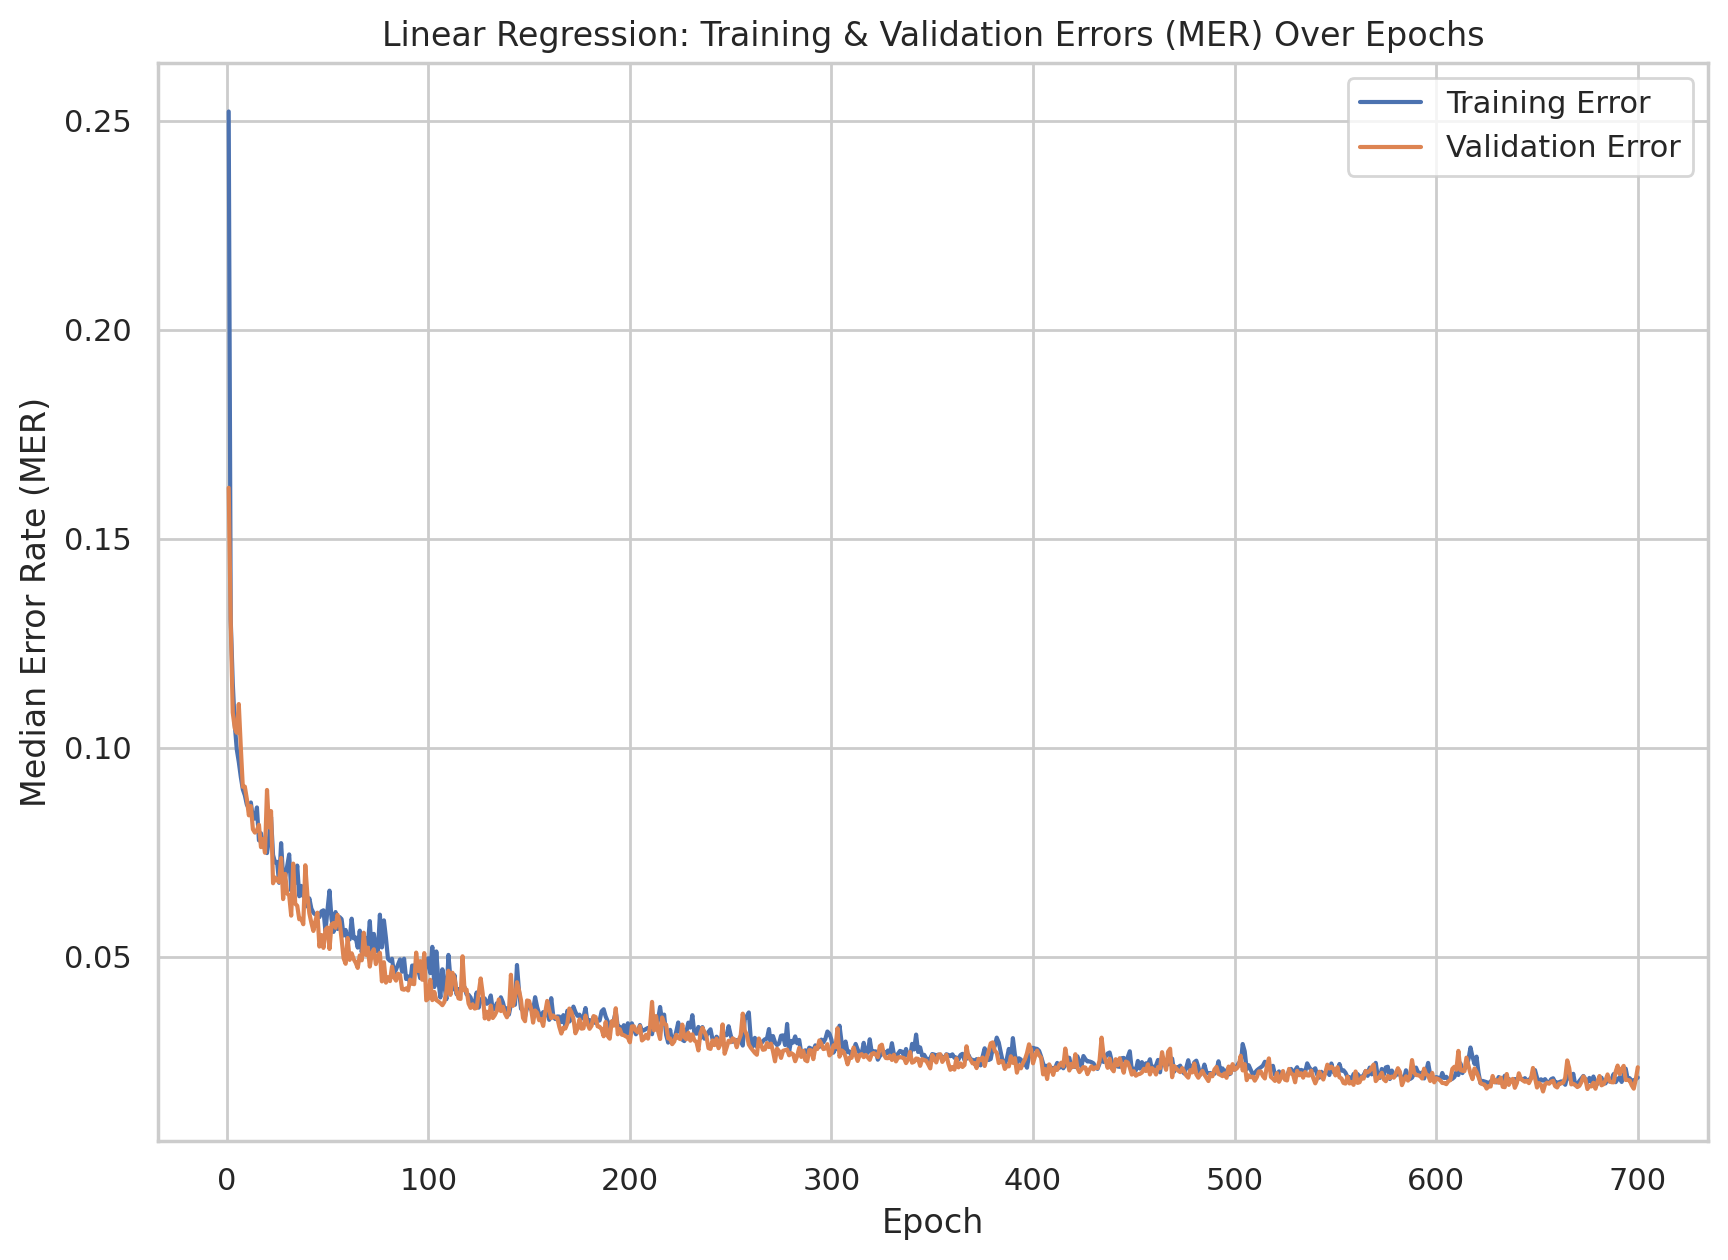

In [ ]:
plot_errors(train_errors, valid_errors, num_epochs=700, label1='Training Error', label2='Validation Error', title='Linear Regression: Training & Validation Errors (MER) Over Epochs')

## 5.A table listing all the model hyperparameters that you have tried with the corresponding validation errors that you found.

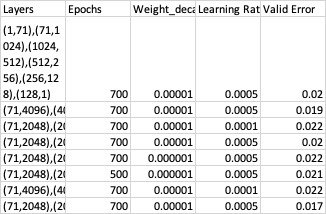

---
## Save Model

Save a `checkpoint.pth` file containing all the necessary information to retrieve your best model and predictions. Remember submitting this file to Canvas siste.

Hint: Check out the `Lecture 4 - Saving and Loading Models.ipynb` on Canvas if you do not know how to save model.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [ ]:
print("Our model: \n\n", model5, '\n')
print("The state dict keys: \n\n", model5.state_dict().keys())

Our model: 

 Sequential(
  (0): Linear(in_features=105, out_features=71, bias=True)
  (1): ReLU()
  (2): Linear(in_features=71, out_features=2048, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=64, bias=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=1, bias=True)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias', '10.weight', '10.bias'])


In [ ]:
torch.save(model5.state_dict(), 'checkpoint.pth')

In [ ]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias', '8.weight', '8.bias', '10.weight', '10.bias'])


In [ ]:
model5.load_state_dict(state_dict)

<All keys matched successfully>

---
## Inference on test data

After the model is trained, we can use it for inference.

In [ ]:
#TODO: write the code to generate predicted sale prices for test data
model5.eval()

test_features = test_features.to(device)

with torch.no_grad():
    predicted_test = model5(test_features) * normalization_factor

predicted_test_cpu = predicted_test.cpu()



In [ ]:
#TODO: save the predicted sale prices into submission_csv
test_withid = pd.read_csv("test.csv")
ids = test_withid['ID'].values

submission = pd.DataFrame({'ID': ids, 'SALE_PRICE': predicted_test_cpu.view(-1)})
submission.to_csv('submission_best_model.csv',index=False)

Now, we can submit our predictions on Kaggle and see how they compare with the actual house prices (labels) on the test set.

- Log in to the Kaggle website and visit the house price prediction competition page.

- Click the “Submit Predictions”.

- Click the “Browse Files” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.

- Click the “Submit” button at the bottom of the page to view your results.

 **Include your best test error shown on Kaggle in your case report!**

---
## Evaluate the profit of iBuyer business model


In class, we have dicussed the iBuyer business model and its opportunities and risks. In the following analysis, imagine you work in a consulting firm and would like to investigate the profitability of the iBuyer business model.

You have taken the Mordern Analytics course and remembered that Prof. X advocated the data-driven approach in business decision making. Thus, you would like to perform analysis based on model and data.

Note that since we do not know the true sale prices in the future (like test data), we need to conduct the analysis based on the historical data (train or validation data). Previously, you have already trained a multilayer perceptron model using the train data. Now, let's evaluate the profit of iBuyer business model based on the predicted prices on the **validation data**.

Let's first compute the predicted prices on the valid data.

## 6. Your profit analysis of the iBuyer business model based on the predicted price on the valid data and answers to the four questions therein.


In [ ]:
## TODO: Load your best model from your saved checkpoint.pth file.
state_dict = torch.load('checkpoint.pth')
model5.load_state_dict(state_dict)

In [ ]:
## TODO: compute the predicted prices on valid data using your best model
model5.eval()
valid_features = valid_features.to(device)
with torch.no_grad():
    predicted_test = model5(valid_features) * normalization_factor

predicted_test_cpu = predicted_test.cpu()
predicted_test_cpu

tensor([[546081.8750],
        [562118.2500],
        [270428.5000],
        ...,
        [622495.1875],
        [575214.8125],
        [277230.6562]])

Compute the signed error rates (without taking the absolute value sign), that is

$$
\text{Signed Error Rate} = \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}}
$$
We will call signed error rate as prediction error henceafter.

In [ ]:
valid_labels = valid_labels.to(device)
valid_labels

tensor([[5.6682],
        [5.9000],
        [2.5500],
        ...,
        [6.3000],
        [5.9300],
        [2.8090]], device='cuda:0')

In [ ]:
## TODO: compute the signed error rates (henceafter called prediction errors)
predicted_test_cpu = predicted_test_cpu.to(device)
signed_error_rates = (predicted_test_cpu/(valid_labels*normalization_factor) - 1)
signed_error_rates

tensor([[-0.0366],
        [-0.0473],
        [ 0.0605],
        ...,
        [-0.0119],
        [-0.0300],
        [-0.0131]], device='cuda:0')

### Analysis and visualization of valid errors

Let's plot the histogram of prediction errors.

**Question 1**: what is the bias of the prediction errors? Include the histogram of prediction errors and the bias in your report.

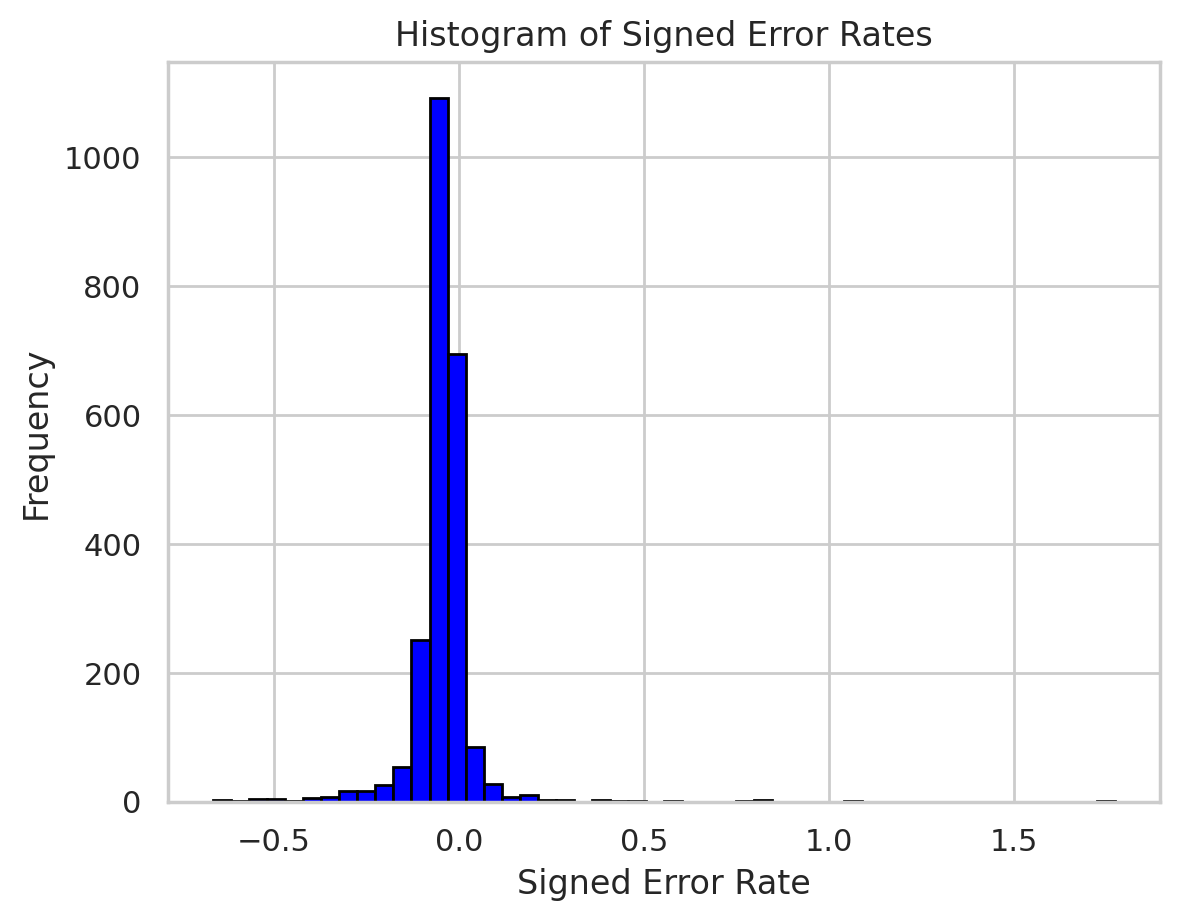

In [ ]:
error_rates = signed_error_rates.cpu().numpy()

# Plot a histogram
plt.hist(error_rates, bins=50, edgecolor='black', color='blue')
plt.title('Histogram of Signed Error Rates')
plt.xlabel('Signed Error Rate')
plt.ylabel('Frequency')
plt.show()

### Profit Analysis

In the following profit analysis, we assume the iBuyer will make an offer to every property in the valid data based on their predicted price $PP$. We assume the iBuyer decides the offer price $OP$ according to
$$
OP = \frac{PP}{1+\alpha},
$$
where $\alpha$ is the (targted) profit margin of the iBuyer.
Here we assume the profit margin has already taken into consideration the commission fee charged by the iBuyer
and various costs associated such as transaction cost, administration cost, and holding cost. Note that the commission fee charged by Zillow is often around $7.5\%$ and Zillow may charge additional repair costs after home inspection. Thus we take $\alpha=12\%$ in this case study.

We further assume that the iBuyer can resell the property at the same
price as the broker in the future once the property is bought. In other words, the resell price is equal to the sale price in the valid data. This assumption may not be exactly true in practice and the iBuyer may sell the house at either a higher or lower price depending on the market trend. But our conclusion will not change too much.

Based on the above two assumptions, we can now determine the percentage profit
for a property bought by the iBuyer as
$$
\frac{SP- OP}{OP}.
$$
We use the percentage profit instead of the absolute profit because the iBuyer cannot hope to purchase all houses in the market. Therefore, the percentage profit is a better measure of the profitability of the iBuyer business model.
 The aim of the iBuyer in this simplified setting is to purchase properties for less money than they are sold for, to generate a profit.

In [ ]:
profit_margin = 0.12

**Question 2**: Consider the hypothetical scenario where the offers are all accepted regardless of their values,
what is the average percentage profit? Do you see a big difference compared to the profit margin $\alpha$? Include your answers in the report.

In [ ]:
OP = predicted_test_cpu / (1 + profit_margin)
perc_profit = (valid_labels*normalization_factor)/OP - 1
avg_percentage_profit = torch.mean(perc_profit)
avg_percentage_profit

tensor(0.1845, device='cuda:0')

**Offer Acceptance Rule**


However, not every offer will be accepted by the home owner. Given an offer price, whether the homeowner accepts it
depends on the homeowner's perceived valuation. For the current dataset, we lack enough data to determine the homeowner's perceived valuation of the property. However, the actual sale price in the valid data serves as a reasonable proxy of the homeowner's perceived valuation. Therefore, we assume that the home owner will accept the offer, if
$$
OP> (1-\beta) SP,
$$
where $\beta$ is a discounting factor. Here the discounting factor captures the commission fee charged
by the conventional realtors which is around 6%, as well as the convenience factor that models
how much the homeowner values the quick transaction services of the iBuyer over the conventional
relator. We assume $\beta = 10\%$ in this case.

**Question 3**: Based on the sale price in the valid data and the acceptance rule, what is the mean percentage profit among all accepted offers? Do you see a big difference compared to the targeted profit margin $\alpha$?  Include your answers in your report.  

In [ ]:
perc_profit2 = ((valid_labels*normalization_factor)/OP - 1)[OP > (0.9 * valid_labels * normalization_factor)]
avg_percentage_profit2 = torch.mean(perc_profit2)
avg_percentage_profit2

tensor(0.0458, device='cuda:0')

Let's plot the histogram of the prediction errors for those properties whose home owners accepted the offer.

**Question 4**: What is the bias of the prediction errors when restricting to those properties whose owners accepted the offer? Based on the histogram and bias, can you explain your answers to Question 3?

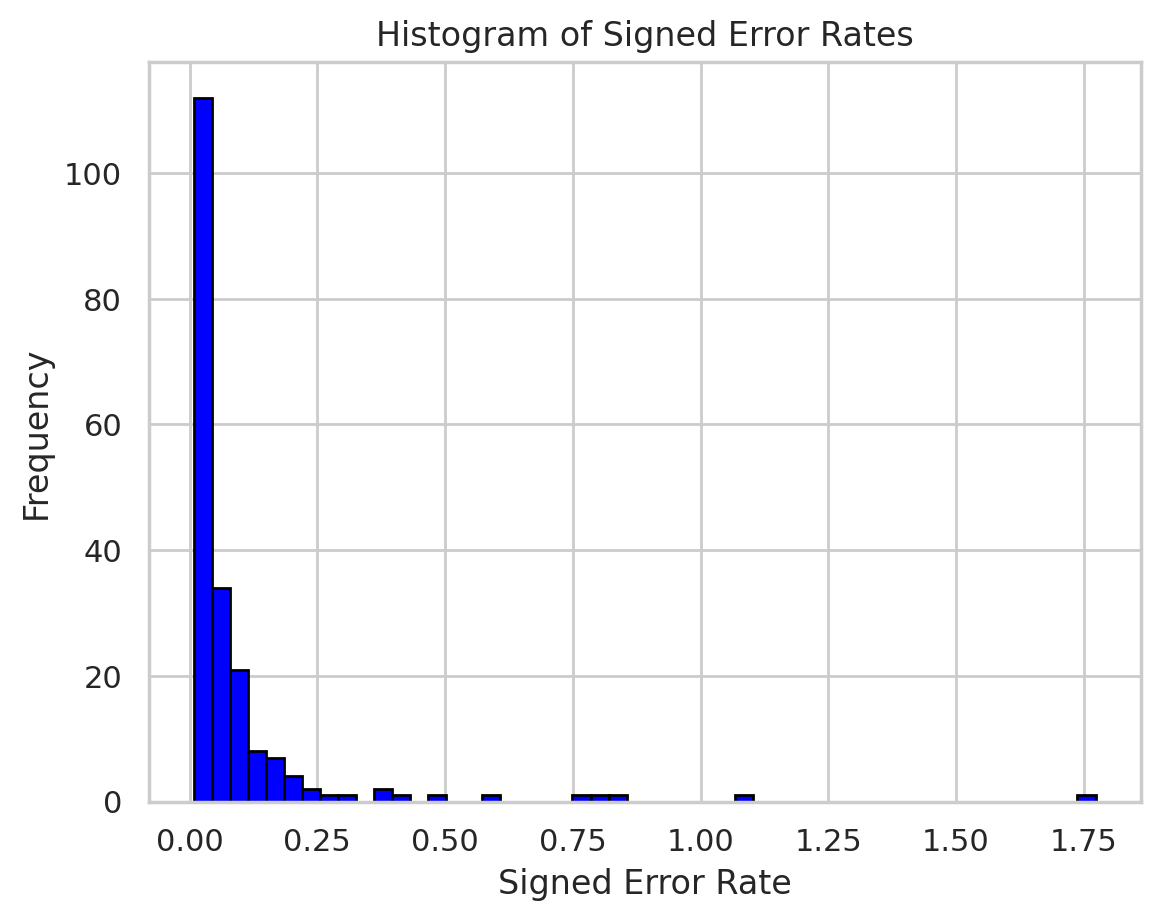

In [ ]:
signed_error_rates2 = (OP*(1+profit_margin)/(valid_labels*normalization_factor) - 1)[OP > (0.9 * valid_labels * normalization_factor)]
error_rates2= signed_error_rates2.cpu().numpy()

# Plot a histogram
plt.hist(error_rates2, bins=50, edgecolor='Black', color='blue')
plt.title('Histogram of Signed Error Rates')
plt.xlabel('Signed Error Rate')
plt.ylabel('Frequency')
plt.show()